# 概要

## 目標
- 不動産価格の単回帰分析

## 持ちデータ
- id:物件の固有番号
- space:部屋の大きさ
- room:間取り
- value：物件価格[万円]

## 事前知識
- 物件価格は部屋の大きさに相関がある

# ライブラリインストール

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.style.use("ggplot")
import seaborn as sns

#import missingno as msno

#from tqdm import tqdm_notebook as tqdm

#import plotly
#plotly.offline.init_notebook_mode(connected=False)

import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

import pystan

# データの確認 

In [10]:
df = pd.read_excel("../data/real_estate1.xlsx")

In [11]:
df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


(array([2., 2., 2., 4., 3., 1., 4., 2., 1., 1., 1.]),
 array([3050.        , 3419.09090909, 3788.18181818, 4157.27272727,
        4526.36363636, 4895.45454545, 5264.54545455, 5633.63636364,
        6002.72727273, 6371.81818182, 6740.90909091, 7110.        ]),
 <a list of 11 Patch objects>)

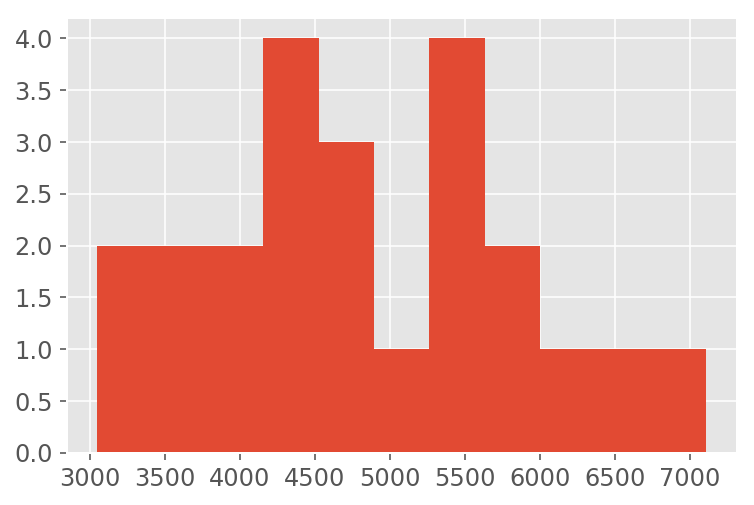

In [17]:
plt.hist(df.value, bins=11)

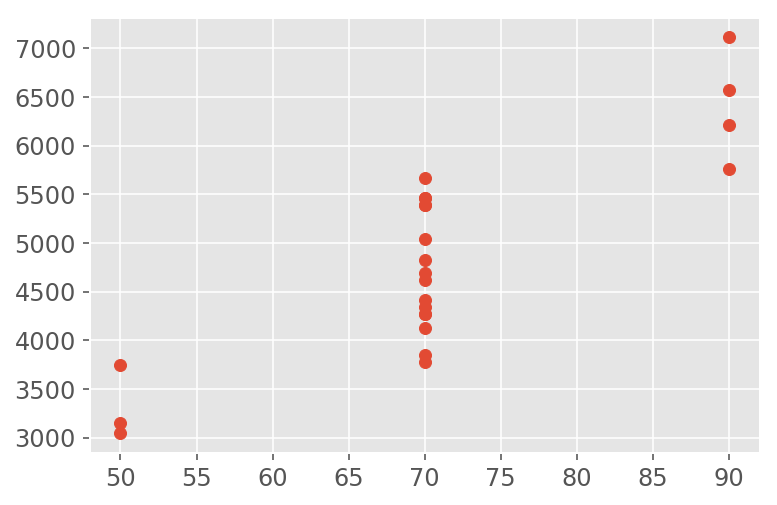

In [18]:
plt.scatter(df.space, df.value)

# 統計モデルの作成
## パラメータ
- N:物件数
- a:傾き
- b：雪片
- x:部屋数
- y:物件価格
- σ：誤差
## 統計モデル
- 物件価格がax+bと表せる
- y[n] ~ Normal(ax[n] + b, σ)

In [20]:
stan_model = """ 

data{
    int N;
    real X[N];
    real Y[N];
}


parameters{
    real a;
    real b;
    real <lower=0> sigma;
 }
 
 model{ 
     
     for (i in 1:N){
         Y[i] ~ normal(a *X[i] + b, sigma);
     }
    
}
""" 

# モデルのコンパイル

In [21]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76aba5a220a5679cd523b55744b04299 NOW.


In [25]:
stan_data = {"N":df.shape[0], "X":df["space"], "Y":df["value"]}

In [26]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500,chains=3, seed=123)

In [27]:
fit

Inference for Stan model: anon_model_76aba5a220a5679cd523b55744b04299.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      79.03    0.34  11.64  55.52  71.61  78.88  86.74  102.2   1175    1.0
b     -764.1   24.21 834.46  -2433  -1315 -764.7 -230.8 907.49   1188    1.0
sigma 614.85    2.95 106.34  447.4 540.73 601.81 673.65 855.25   1303    1.0
lp__  -152.0    0.04   1.35 -155.3 -152.6 -151.6 -151.0 -150.5   1096    1.0

Samples were drawn using NUTS at Mon Jan  7 17:28:54 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

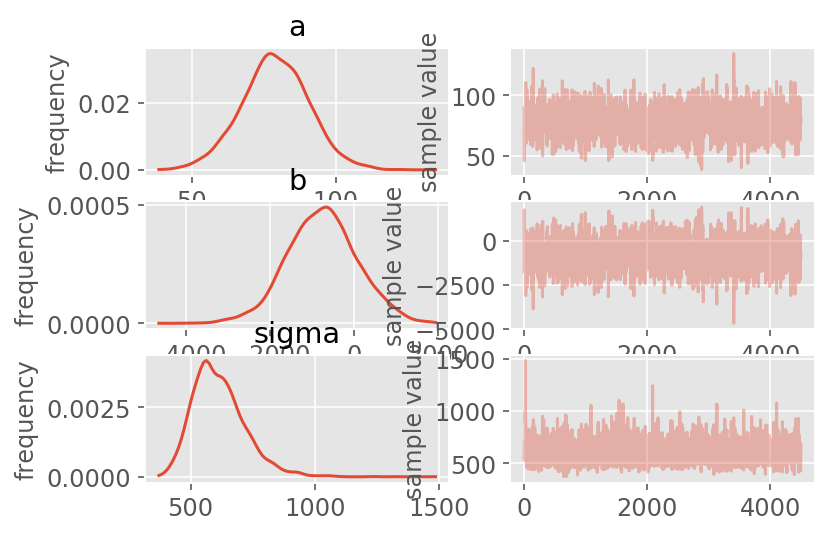

In [29]:
fig = fit.plot()

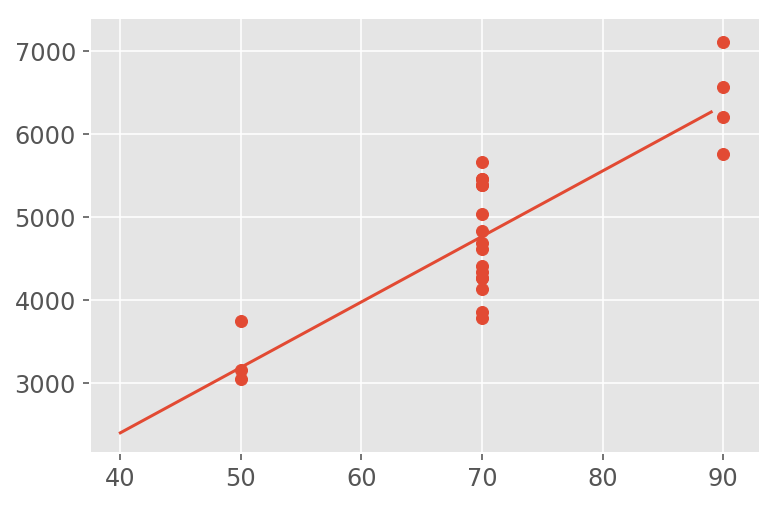

In [30]:
a = 79.03 
b = -764.1 
x = np.arange(40, 90, 1)
y = a * x + b
plt.plot(x, y)
plt.scatter(df.space, df.value)